File path: c:\Users\getne\30122-project-gitmoney\data\calls_money


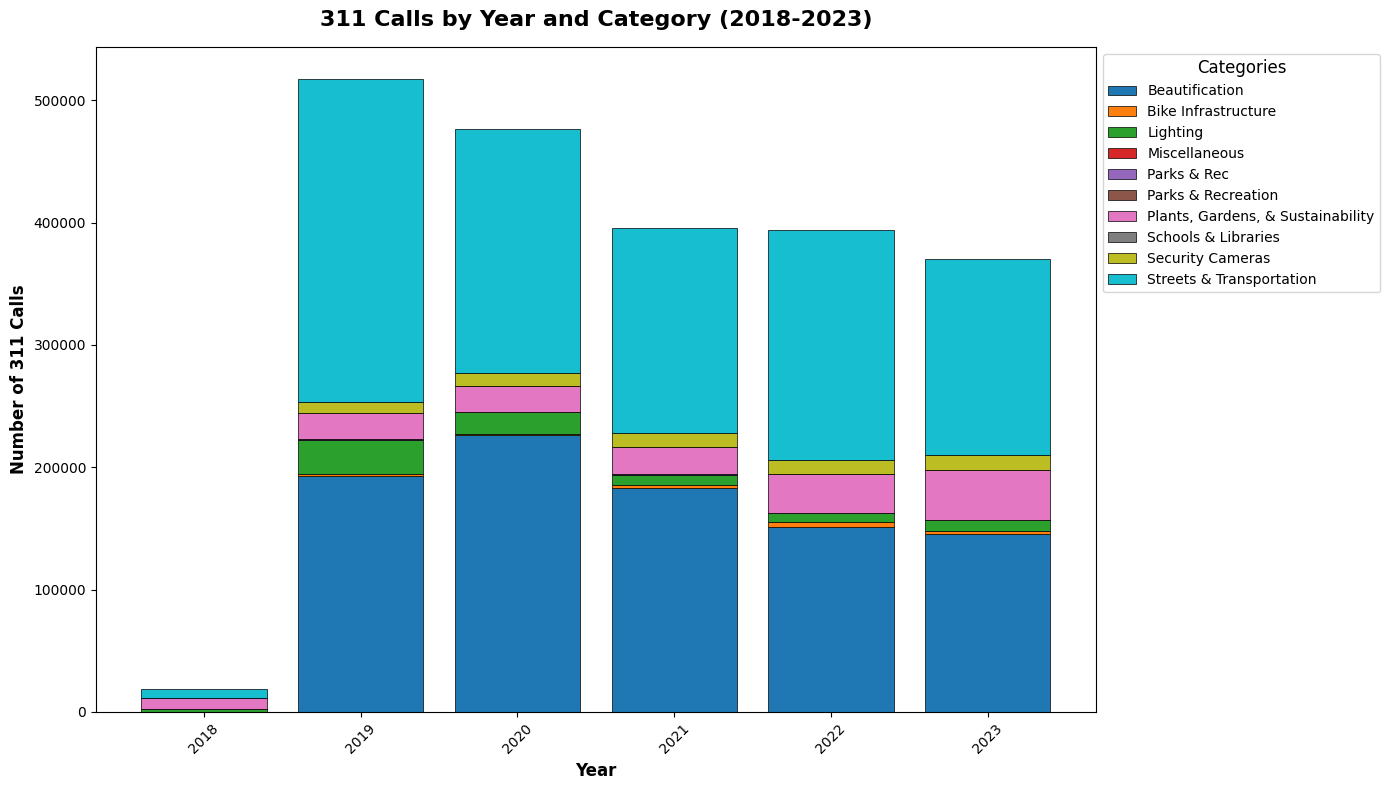

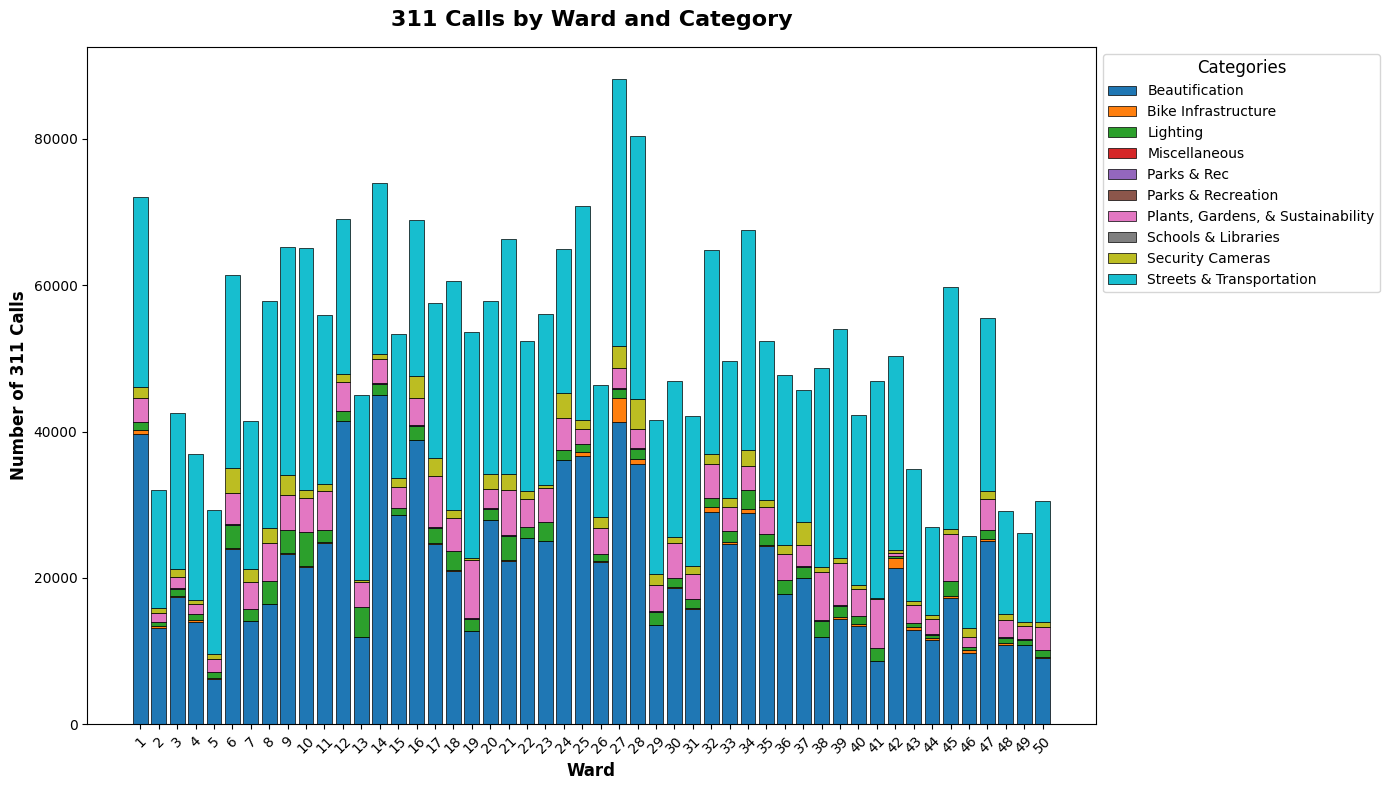

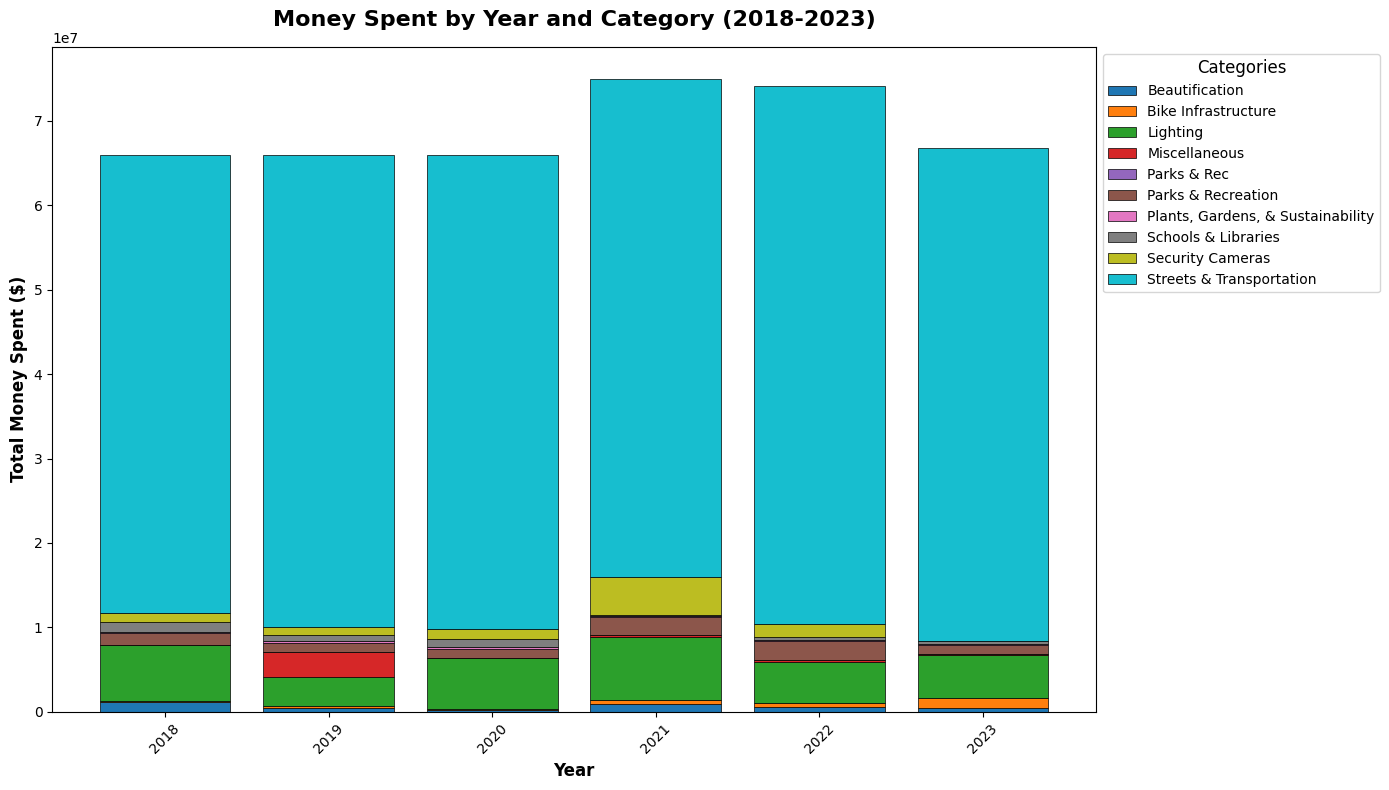

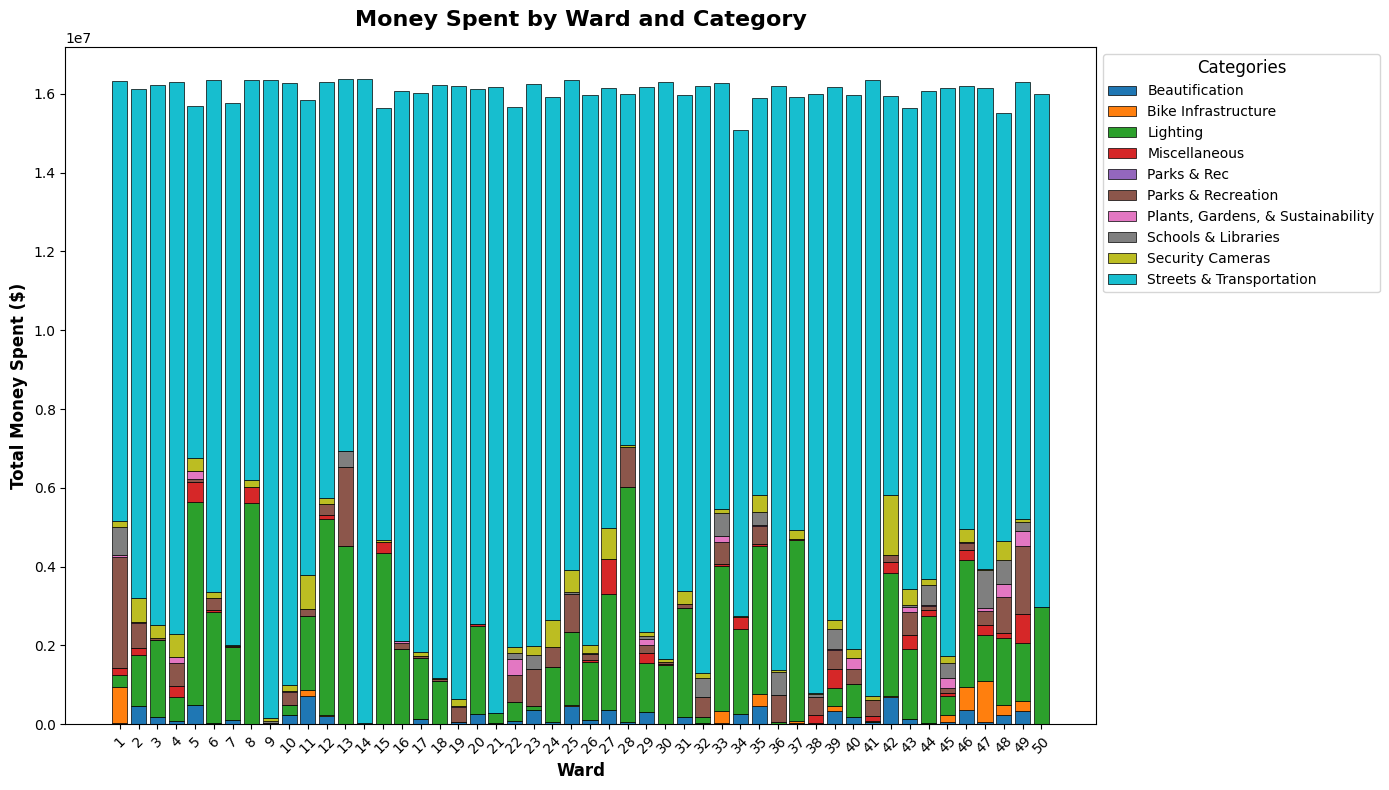

In [34]:
import csv
import pathlib
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the path to the CSV file
current_directory = pathlib.Path.cwd()
csv_file = current_directory.parent.parent / "30122-project-gitmoney" / "data" / "calls_money"

# Print the file path for verification
print(f"File path: {csv_file}")

def plot_calls_by_year_and_ward(csv_file: pathlib.Path):
    """
    Plot four stacked bar charts: calls and money spent by year and ward, categorized.

    Parameters:
        csv_file (Path): Path to CSV file with year, ward, category, calls, and total_cost

    Returns:
        None (displays four plots)
    """
    # Load CSV data 
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        data = [{k.strip(): v for k, v in row.items()} for row in reader]

    # Aggregate data in a single pass for all four charts
    calls_by_year = defaultdict(lambda: defaultdict(int))
    calls_by_ward = defaultdict(lambda: defaultdict(int))
    money_by_year = defaultdict(lambda: defaultdict(float))
    money_by_ward = defaultdict(lambda: defaultdict(float))

    for entry in data:
        year = int(entry['year'])
        ward = int(entry['ward'])
        category = entry['category']
        calls = int(entry['calls'])
        cost = float(entry['total_cost'])

        if 2018 <= year <= 2023:
            calls_by_year[year][category] += calls
            money_by_year[year][category] += cost
        
        calls_by_ward[ward][category] += calls
        money_by_ward[ward][category] += cost

    # Extract sorted keys once for reuse
    years = sorted(calls_by_year.keys())
    wards = sorted(calls_by_ward.keys())
    categories = sorted(set().union(*[set(calls_by_year[y].keys()) for y in years]))

  
    def plot_stacked_bars(x_values, data_dict, title, x_label, y_label):
        plt.figure(figsize=(14, 8))  
        bottom = [0] * len(x_values)
        for category in categories:
            values = [data_dict[x].get(category, 0) for x in x_values]
            plt.bar(x_values, values, bottom=bottom, label=category, edgecolor='black', linewidth=0.5)  
            bottom = [b + v for b, v in zip(bottom, values)]  
        
        # Bold and larger titles/labels
        plt.title(title, fontsize=16, fontweight='bold', pad=15)
        plt.xlabel(x_label, fontsize=12, fontweight='bold')
        plt.ylabel(y_label, fontsize=12, fontweight='bold')
        plt.xticks(x_values, rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        
        # Add grid 
        #plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Enhanced legend
        plt.legend(title='Categories', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
        
        plt.tight_layout()
        plt.show()

    # Plot all four charts with enhanced visualization
    plot_stacked_bars(years, calls_by_year, '311 Calls by Year and Category (2018-2023)', 'Year', 'Number of 311 Calls')
    plot_stacked_bars(wards, calls_by_ward, '311 Calls by Ward and Category', 'Ward', 'Number of 311 Calls')
    plot_stacked_bars(years, money_by_year, 'Money Spent by Year and Category (2018-2023)', 'Year', 'Total Money Spent ($)')
    plot_stacked_bars(wards, money_by_ward, 'Money Spent by Ward and Category', 'Ward', 'Total Money Spent ($)')

# Test with real data
if __name__ == "__main__":
    plot_calls_by_year_and_ward(csv_file)

File path: c:\Users\getne\30122-project-gitmoney\data\calls_money


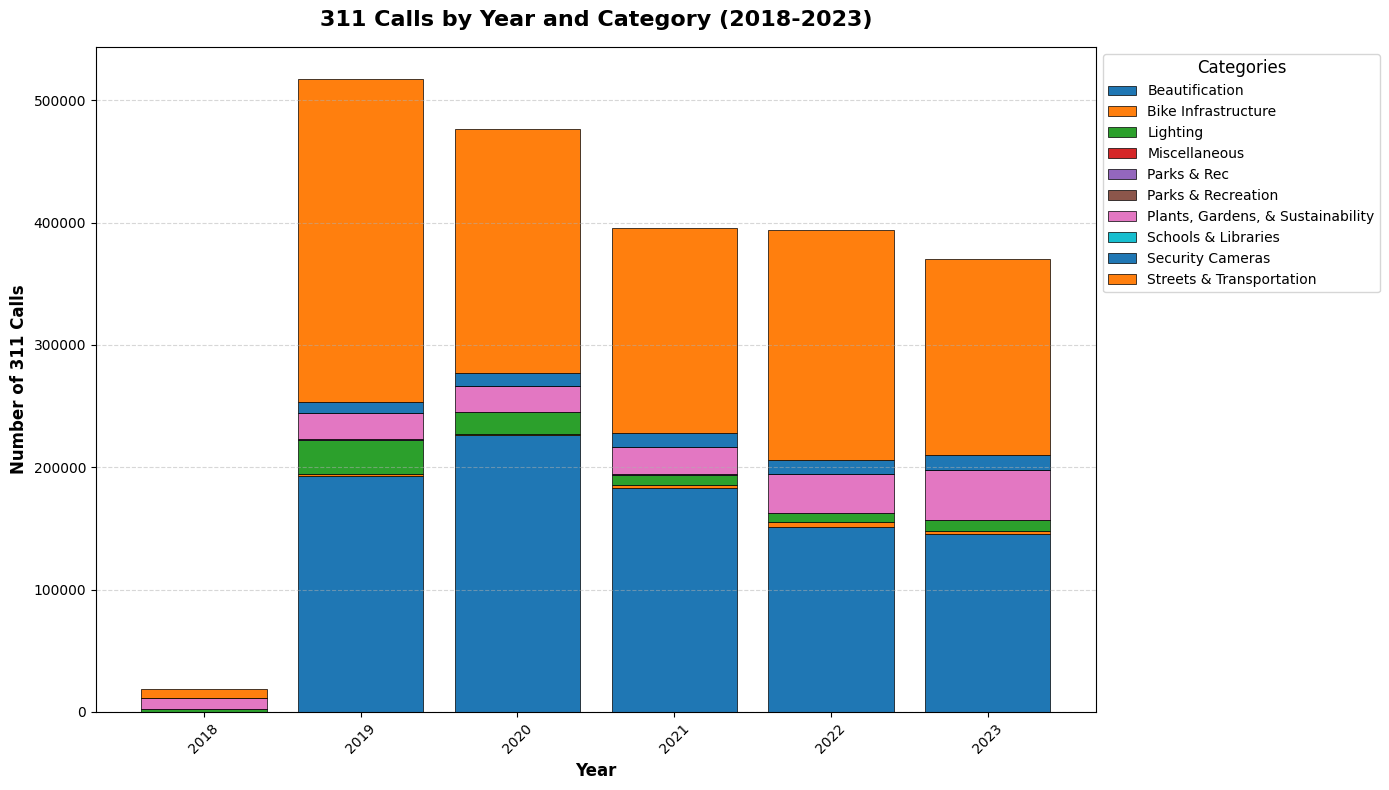

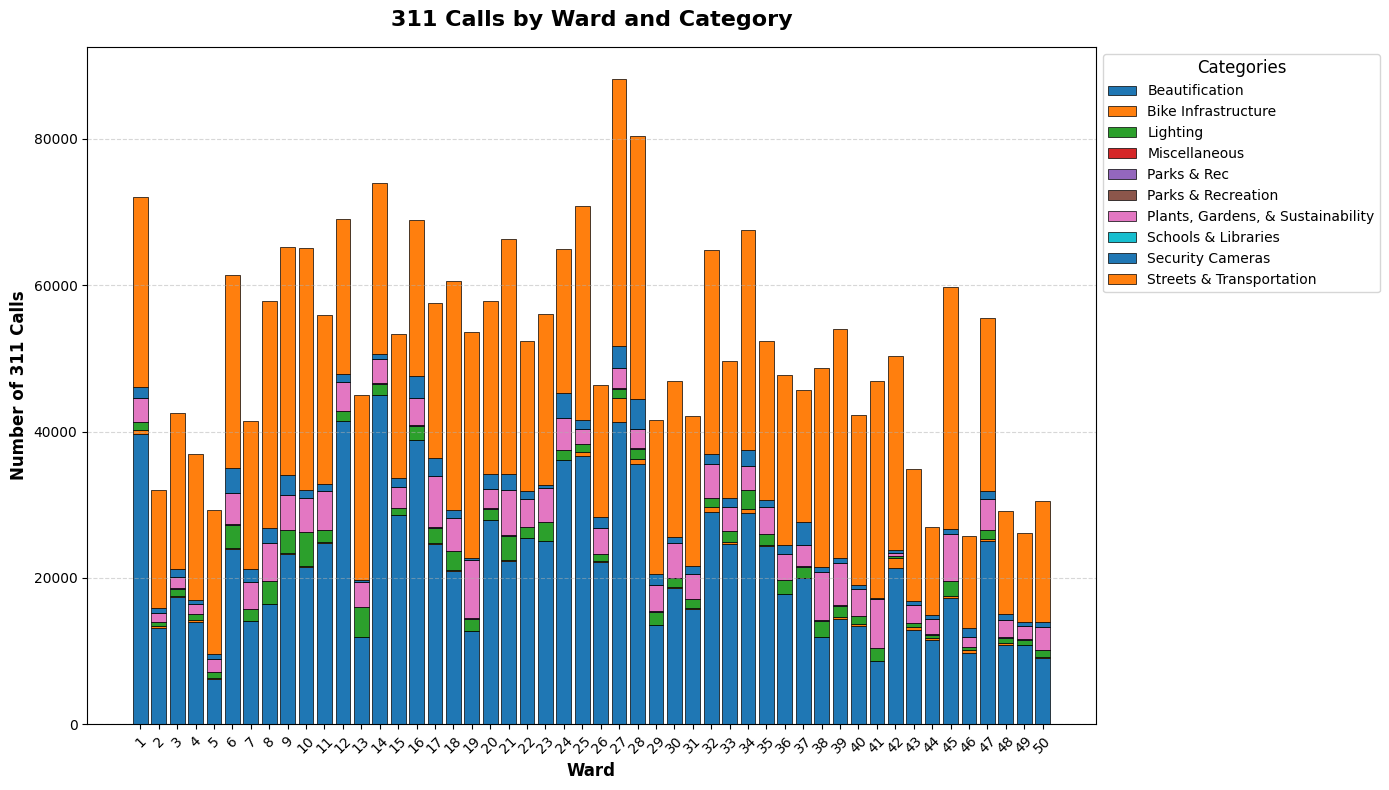

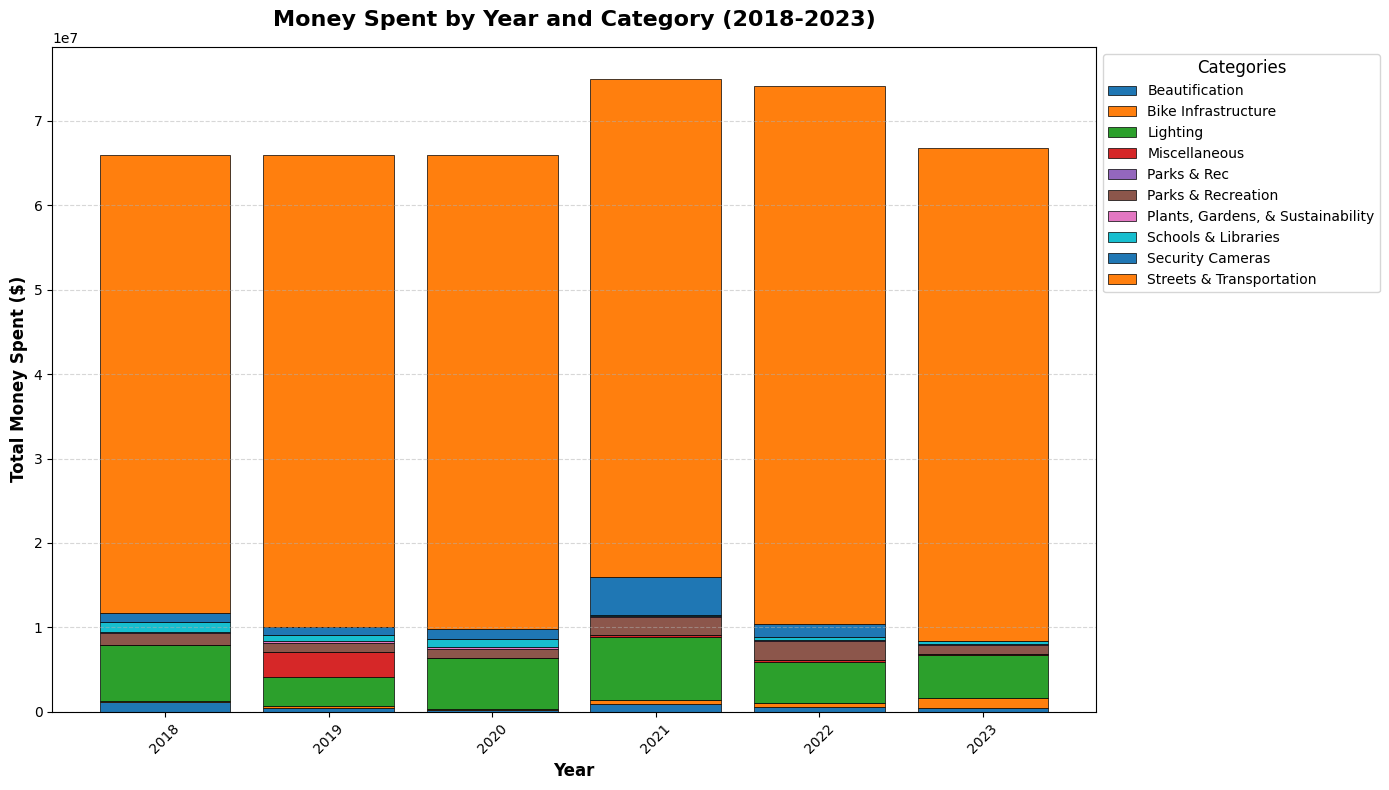

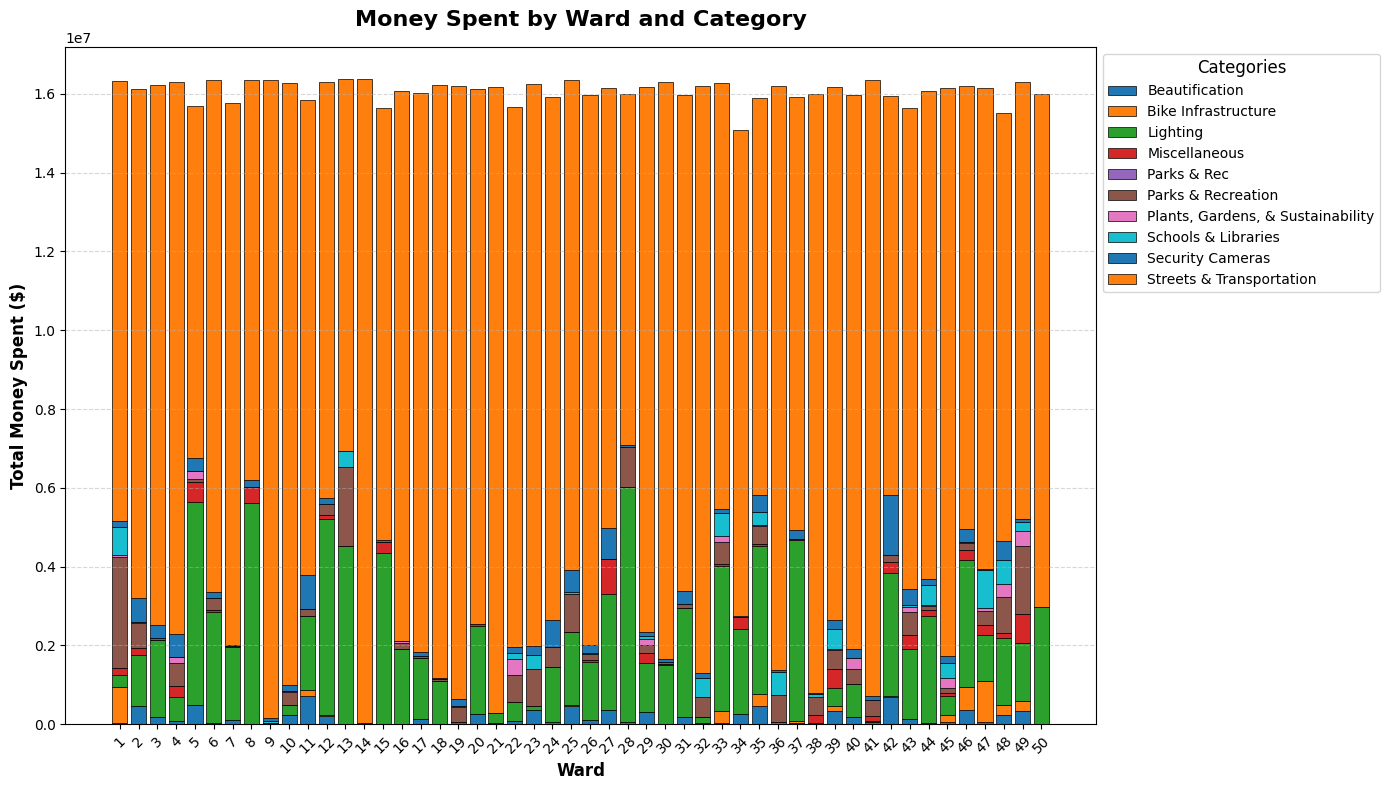

In [36]:
import csv
import pathlib
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the CSV file path
csv_file = pathlib.Path.cwd().parent.parent / "30122-project-gitmoney" / "data" / "calls_money"
print(f"File path: {csv_file}")

def plot_calls_by_year_and_ward(csv_file: pathlib.Path):
    """
    Plot four stacked bar charts: calls and money spent by year and ward, categorized.

    Parameters:
        csv_file (Path): Path to CSV file with year, ward, category, calls, and total_cost

    Returns:
        None (displays four plots)
    """
    # Load CSV data with error handling
    
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        data = [{k.strip(): float(v) if k in ('calls', 'total_cost') else int(v) if k in ('year', 'ward') else v 
                    for k, v in row.items()} for row in reader]


    # Single-pass aggregation
    calls_by_year = defaultdict(lambda: defaultdict(int))
    calls_by_ward = defaultdict(lambda: defaultdict(int))
    money_by_year = defaultdict(lambda: defaultdict(float))
    money_by_ward = defaultdict(lambda: defaultdict(float))

    for entry in data:
        year = entry['year']
        ward = entry['ward']
        category = entry['category']
        calls = entry['calls']
        cost = entry['total_cost']

        if 2018 <= year <= 2023:
            calls_by_year[year][category] += calls
            money_by_year[year][category] += cost
        calls_by_ward[ward][category] += calls
        money_by_ward[ward][category] += cost

    # Extract sorted keys
    years = sorted(calls_by_year.keys())
    wards = sorted(calls_by_ward.keys())
    categories = sorted(set().union(*[set(calls_by_year[y].keys()) for y in years]))

    #  8-color palette 
    color_palette = [
        '#1f77b4',  # Blue
        '#ff7f0e',  # Orange
        '#2ca02c',  # Green
        '#d62728',  # Red
        '#9467bd',  # Purple
        '#8c564b',  # Brown
        '#e377c2',  # Pink
        '#17becf'   # Teal
    ]
    if len(categories) > len(color_palette):
        print(f"Warning: {len(categories)} categories exceed palette size ({len(color_palette)}). Colors will repeat.")
    category_colors = {cat: color_palette[i % len(color_palette)] for i, cat in enumerate(categories)}

    # plotting function
    def plot_stacked_bars(x_values, data_dict, title, x_label, y_label):
        plt.figure(figsize=(14, 8))
        bottom = [0] * len(x_values)
        for category in categories:
            values = [data_dict[x].get(category, 0) for x in x_values]
            plt.bar(x_values, values, bottom=bottom, label=category, color=category_colors[category],
                    edgecolor='black', linewidth=0.5)
            bottom = [b + v for b, v in zip(bottom, values)]  
        
        plt.title(title, fontsize=16, fontweight='bold', pad=15)
        plt.xlabel(x_label, fontsize=12, fontweight='bold')
        plt.ylabel(y_label, fontsize=12, fontweight='bold')
        plt.xticks(x_values, rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.legend(title='Categories', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()

    # Plot all four charts
    plot_stacked_bars(years, calls_by_year, '311 Calls by Year and Category (2018-2023)', 'Year', 'Number of 311 Calls')
    plot_stacked_bars(wards, calls_by_ward, '311 Calls by Ward and Category', 'Ward', 'Number of 311 Calls')
    plot_stacked_bars(years, money_by_year, 'Money Spent by Year and Category (2018-2023)', 'Year', 'Total Money Spent ($)')
    plot_stacked_bars(wards, money_by_ward, 'Money Spent by Ward and Category', 'Ward', 'Total Money Spent ($)')

# Run with real data
if __name__ == "__main__":
    plot_calls_by_year_and_ward(csv_file)